In [1]:
!git clone -b main https://github.com/nguyenrtm/DDI-KT-2024.git
!pip install xmltodict
!python -m spacy download en_core_web_lg

Cloning into 'DDI-KT-2024'...
remote: Enumerating objects: 1295, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 1295 (delta 122), reused 258 (delta 122), pack-reused 1037
Receiving objects: 100% (1295/1295), 43.80 MiB | 20.40 MiB/s, done.
Resolving deltas: 100% (765/765), done.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [2]:
import sys
sys.path.append('./DDI-KT-2024')
sys.path.append('./DDI-KT-2024/src')

In [3]:
from tqdm import tqdm
from pprint import pprint

from utils import *
from reader.ddi_reader import *
from preprocess.spacy_nlp import *
from preprocess.clean import *
from dependency_parsing.dependency_parser import *
from dependency_parsing.path_processer import *
from model.custom_dataset import *
from model.word_embedding import *
from model.trainer import *
from model.model import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
lookup_word = get_lookup('./DDI-KT-2024/data/fasttext/nguyennb/all_words.txt')
lookup_tag = get_lookup('./DDI-KT-2024/data/fasttext/nguyennb/all_pos.txt')
lookup_dep = get_lookup('./DDI-KT-2024/data/fasttext/nguyennb/all_dep.txt')
lookup_direction = get_lookup('./DDI-KT-2024/data/fasttext/nguyennb/all_direction.txt')

In [5]:
# all_mapped_sdp = create_mapping_all(path_processed_train)

In [6]:
all_candidates_train = load_pkl('./DDI-KT-2024/data/pkl/candidates.train.pkl')
all_candidates_test = load_pkl('./DDI-KT-2024/data/pkl/candidates.test.pkl')
sdp_train = load_pkl('./DDI-KT-2024/data/pkl/sdp.train.pkl')
sdp_test = load_pkl('./DDI-KT-2024/data/pkl/sdp.test.pkl')
sdp_train_mapped = load_pkl('./DDI-KT-2024/data/pkl/train.mapped.sdp.pkl')
sdp_test_mapped = load_pkl('./DDI-KT-2024/data/pkl/test.mapped.sdp.pkl')
we = WordEmbedding(fasttext_path='./DDI-KT-2024/data/fasttext/nguyennb/fastText_ddi.npz',
                   vocab_path='./DDI-KT-2024/data/fasttext/nguyennb/all_words.txt')

In [7]:
y_train = get_labels(all_candidates_train)
y_test = get_labels(all_candidates_test)

In [8]:
data_train = CustomDataset(sdp_train_mapped, y_train)
data_train.fix_exception()
data_train.batch_padding(batch_size=128)
data_train.squeeze()
data_test = CustomDataset(sdp_test_mapped, y_test)
data_test.fix_exception()
data_test.batch_padding(batch_size=128)
data_test.squeeze()

In [9]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(data_train, batch_size=128)
dataloader_test = DataLoader(data_test, batch_size=128)

In [19]:
import wandb

wandb.login()
wandb.init(
    # Set the project where this run will be logged
    project="DDI-KT-2024",
    # Track hyperparameters and run metadata
    config={
        "representation": "SDP",
        "features": "fasttext, tag, position",
        "weight_decay": 1e-3,
        "lr": 0.0001,
        "batch_size": 128,
        "epochs": 300,
        "dropout_rate": 0,
        "word_embedding_size": 200,
        "tag_number": 51,
        "tag_embedding_size": 50,
        "position_number": 4,
        "position_embedding_size": 50,
        "direction_number": 3,
        "direction_embedding_size": 50,
        "edge_number": 46,
        "edge_embedding_size": 200,
        "token_embedding_size": 500,
        "dep_embedding_size": 500,
        "conv1_out_channels": 256,
        "conv2_out_channels": 256,
        "conv3_out_channels": 256,
        "conv1_length": 1,
        "conv2_length": 2,
        "conv3_length": 3,
        "w_false": 27792 / 23771,
        "w_advice": 27792 / 826,
        "w_effect": 27792 / 1687,
        "w_mechanism": 27792 / 1319,
        "w_int": 27792 / 189,
        "device": "cuda"
    }
)
config = wandb.config

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▃▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_f_advise,▁▄▃▄▅▅▅▅▆▅▆▆▇▇▅▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
val_f_effect,▂▁▂▁▂▂▂▃▃▃▃▃▅▆▂▆▅▆▄▅▇▆▆▇▇▇▇▇▇▇▇▇███▆█▇▇▇
val_f_false,▇▂▁▁▂▂▂▄▅▅▅▅▆▇▅▆▆▆▆▆▇▇▇▇▇▇▇▇██▇████▇██▇█
val_f_int,▁▃▃▃▃▃▄▄▄▄▅▅▅▅▄▆▆▆▆▆▆▆▇▇▆▇▇▇▇█▇▇███▇████
val_f_mechanism,▄▅▆▆▆▆▆▆▇▇▇▇▇▇▁▇▇▇▇▇▇█▇▇▇▇█▇██▇██████▇▇█
val_loss,█▃▂▂▁▁▁▁▁▁▁▂▁▁▃▁▁▁▂▁▂▂▁▁▁▂▁▁▂▂▂▂▂▂▂▂▃▂▁▂
val_micro_f1,▁▁▂▂▃▃▃▃▄▄▄▄▅▆▂▆▆▆▅▆▇▇▆▇▇▇▇▇▇▇▇▇███▇██▇█
train_loss,814.11971
val_f_advise,0.44135
val_f_effect,0.51745


In [20]:
model = Trainer(we,
                dropout_rate=config.dropout_rate,
                word_embedding_size=config.word_embedding_size,
                tag_number=config.tag_number,
                tag_embedding_size=config.tag_embedding_size,
                position_number=config.position_number,
                position_embedding_size=config.position_embedding_size,
                direction_number=config.direction_number,
                direction_embedding_size=config.direction_embedding_size,
                edge_number=config.edge_number,
                edge_embedding_size=config.edge_embedding_size,
                token_embedding_size=config.token_embedding_size,
                dep_embedding_size=config.dep_embedding_size,
                conv1_out_channels=config.conv1_out_channels,
                conv2_out_channels=config.conv2_out_channels,
                conv3_out_channels=config.conv3_out_channels,
                conv1_length=config.conv1_length,
                conv2_length=config.conv2_length,
                conv3_length=config.conv3_length,
                w_false=config.w_false,
                w_advice=config.w_advice,
                w_effect=config.w_effect,
                w_mechanism=config.w_mechanism,
                w_int=config.w_int,
                target_class=5,
                lr=config.lr,
                weight_decay=config.weight_decay,
                device='cuda')

In [21]:
model.train(dataloader_train, dataloader_test, num_epochs=config.epochs)

100%|██████████| 200/200 [25:59<00:00,  7.80s/it]


train_loss,█▅▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f_advise,▁▁▃▃▄▄▄▅▅▆▆▅▆▆▇▇▆▆▆▆▆▆▆▇▆▆▇▇▆▇▇▇▇▄▇▇█▇▇█
val_f_effect,▁▃▃▄▄▄▅▇▇▇▇▄▇▇▇▇▇▇▆█▆▇██▇▇▇▇▇▇▇█▇▆█▇█▇▇▇
val_f_false,▄▁▃▄▄▅▄▆▆▇▇▆▇▇▇▇▇▇▇█▇███▇▇█▇█████▇████▇█
val_f_int,▁▃▄▄▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇██▇▇▇▇█████████▇▇▇▇▇▇
val_f_mechanism,▁▃▄▄▅▆▅▆▆▆▇▆▇▇▇▆▇▇▇▆▇▇▇█▇▇▇▇▇▇▇▆▇▆▇▇▇▆▆▇
val_loss,█▃▂▂▂▃▁▂▂▃▃▃▂▃▃▂▃▃▃▄▃▄▄▃▂▂▃▂▃▃▂▃▃▃▄▃▃▃▂▃
val_micro_f1,▁▂▃▄▄▄▅▆▆▆▇▅▇▇▇▇▇▇▆▇▇▇▇█▇▇▇▇▇▇▇▇▇▆███▇▇█
train_loss,1039.68344
val_f_advise,0.49107
val_f_effect,0.55376


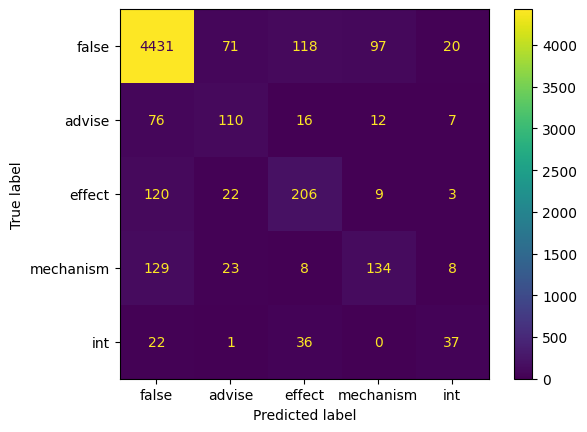

In [22]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=model.plot_confusion_matrix(dataloader_test),
                              display_labels=['false', 'advise', 'effect', 'mechanism', 'int'])
disp.plot()